# **Imports**

Importation des modules

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from PIL import Image,ImageDraw
import skimage.morphology as morpho
from skimage.segmentation import watershed,mark_boundaries
import scipy.spatial as sp

Importation des images

In [2]:
ima = io.imread('./grismontagne.png')
img = io.imread('./montagne.jpg')
ima = img[:,:,0]

# **Prétraitement**

In [3]:
def preprocessing(ima, step):
    im = morpho.area_opening(ima, area_threshold= step*step/16)
    im = morpho.area_closing(im, area_threshold= step*step/16)
    return im

**Affichage des résultats**

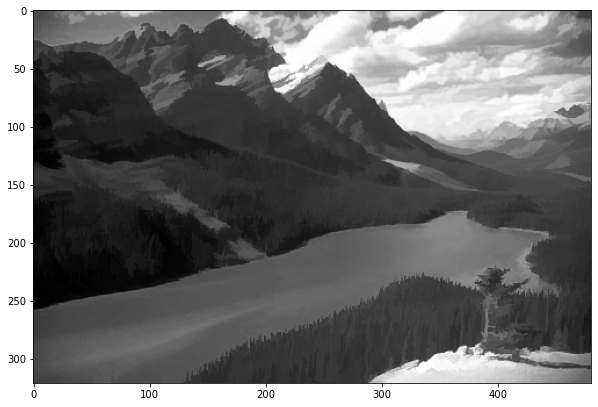

In [4]:
ima = preprocessing(ima,30)
plt.figure(figsize = (10,10))
plt.imshow(ima,cmap='gray')
plt.show()

# **Gradients**

### **Gradient de sobel**

In [5]:
# Gradient horizental
def sobelGradX(ima):

    nl,nc=ima.shape
    gradx=np.zeros((nl,nc))
    for i in range(1,nl-1):
        for j in range(1,nc-1):
            gradx[i,j]=ima[i-1,j+1]+2*ima[i,j+1]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i,j-1]-ima[i+1,j-1];
            
    return gradx

# Gradient vertical
def sobelGradY(ima):

    nl,nc=ima.shape
    grady=np.zeros((nl,nc))
    for i in range(1,nl-1):
        for j in range(1,nc-1):
            grady[i,j]=ima[i+1,j-1]+2*ima[i+1,j]+ima[i+1,j+1]-ima[i-1,j-1]-2*ima[i-1,j]-ima[i-1,j+1];
        
    return grady

# Norme du gradient
def sobel_normeGradient(ima):
    gradx=sobelGradX(ima)
    grady=sobelGradY(ima)
    nl,nc=gradx.shape
    norme=np.zeros((nl,nc))
    for i in range(nl):
        for j in range(nc):
            norme[i,j]=np.sqrt(gradx[i,j]*gradx[i,j]+grady[i,j]*grady[i,j])
            
    return norme

### **Gradient Morphologique**

In [6]:
def gradmorpho(img):

  strell = morpho.disk(1)
  morpho_grad = morpho.dilation(img,strell) - morpho.erosion(img, strell)

  return morpho_grad

### **Gradient LAB**

In [7]:
def gradientlab(img):

  lab = color.rgb2lab(img)
  l = lab[:,:,0]
  gradlab=sobel_normeGradient(l)

  return gradlab

### **Affichage de l'image initiale et du gradient**

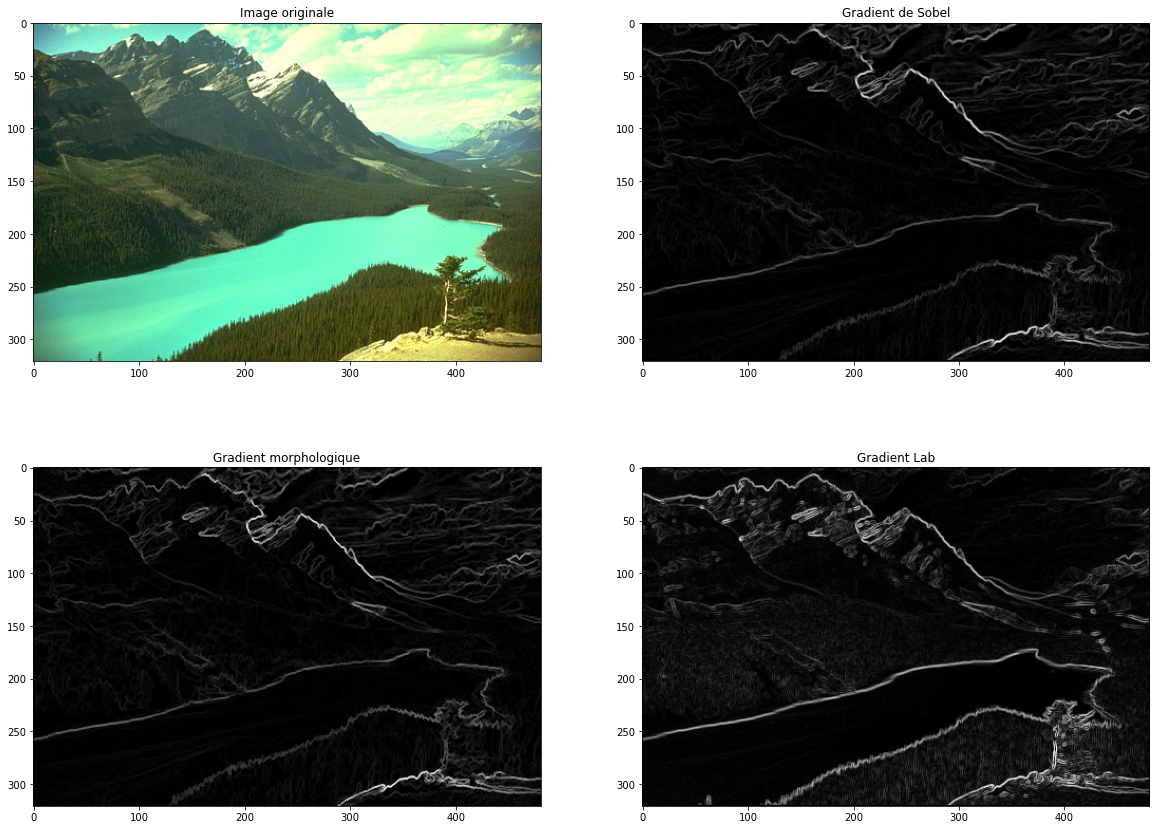

In [8]:
# Gradient de Sobel
gradsob=sobel_normeGradient(ima)

# Gradient morphologique
grad_morpho = gradmorpho(ima)

# Gradient Lab
gradlab = gradientlab(img)

# Affichage des gradients
fig,ax = plt.subplots(2,2,figsize = (20,15))
ax[0,0].imshow(img)
ax[0,0].set_title('Image originale')
ax[0,1].imshow(gradsob,cmap = "gray")
ax[0,1].set_title('Gradient de Sobel')
ax[1,0].imshow(grad_morpho,cmap = "gray")
ax[1,0].set_title('Gradient morphologique')
ax[1,1].imshow(gradlab,cmap = "gray")
ax[1,1].set_title('Gradient Lab')
plt.show()

**Adaptation des types pour les fonctions**

In [9]:
"""
gradlab=np.asarray(gradlab)
plt.imshow(gradlab,cmap='gray')
im = Image.fromarray(np.uint8(grad_morpho))
"""

"\ngradlab=np.asarray(gradlab)\nplt.imshow(gradlab,cmap='gray')\nim = Image.fromarray(np.uint8(grad_morpho))\n"

# **Grille hexagoanle**

### **Calcul des coins de l'hexagone a partir du centre et de la taille**

In [10]:
def hexagon_corners(center,size):
      
    x = center[0]
    y = center[1]

    w = math.sqrt(3) * size
    h = 2 * size

    return [ 
        (x - w / 2, y - h / 4),
        (x, y - h /2),
        (x + w/2, y - h / 4),
        (x + w/2, y + h/4),
        (x, y + h/2),
        (x - w / 2, y + h/4)
    ]

### **Construction de la grille hexagonale**

In [11]:
def hexagon(im, hexagon_size):
  
    im_hex=im.copy()
    draw = ImageDraw.Draw(im_hex)
    w = math.sqrt(3) * hexagon_size
    h = 2 * hexagon_size
    l = []

    num_hor = int(im.size[0] / w) + 2
    num_ver = int(im.size[1] / h * 4 / 3) + 2

    for i in range(0,num_hor*num_ver): 
        
        column = i % num_hor
        row = i // num_hor
        even = row % 2  
        x = column*w + even * w/2
        y = row*h * 3/4
        p = hexagon_corners((x, y), hexagon_size)
        if (x >= 0) and (x <= im.size[0]-1) and (y >= 0) and (y <= im.size[1]-1):
          l.append((int(x), int(y)))
        draw.polygon(p, outline ="white")

    draw.point(l)

    return im_hex,l

**Affichage des résultats**

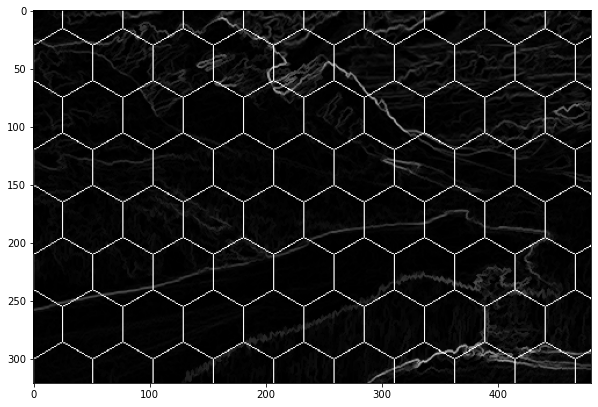

In [12]:
im = Image.fromarray(np.uint8(grad_morpho))
plt.figure(figsize = (10,10))
Im,centres = hexagon(im, 30)
plt.imshow(Im,cmap='gray')

# **Carte des distances**

### **Distances de chanfrein de masque :**
\begin{bmatrix}
1 & 1 & 1\\
1 & 0 & 1\\
1 & 1 & 1
\end{bmatrix}

In [13]:
def cartedesdistances(im,centres):

  nl,nc=im.shape
  carte=np.zeros((nl,nc))
  #Initialisation
  carte.fill(10000)

  for point in centres:
    carte[int(point[1]),[int(point[0])]]=0

  #Premier demi-masque
  mask1=np.array([1,1,1,1,0,10000])
  mask1=mask1.reshape(2,3)
  #Premier balayage
  
  for x in range(nl-1):
    for y in range(nc-2):
      l=[]
      for i in range(2):
        for j in range(3):
          l.append(carte[x+i][y+j]+mask1[i][j])
      carte[x+1][y+1]=np.min(l)

  #Correction des effets de bords
  carte[0][0]=np.min([carte[0][0],carte[0][1]+1,carte[1][0]+1])
  carte[0][nc-1]=np.min([carte[0][nc-1],carte[0][2]+1,carte[1][nc-1]+1])
  carte[nl-1][0]=np.min([carte[nl-1][0],carte[nl-2][0]+1,carte[nl-1][1]+1])
  carte[nl-1][nc-1]=np.min([carte[nl-1][nc-1],carte[nl-2][nc-1]+1,carte[nl-1][nc-2]+1])

  for x in range (1,nl-1):
    carte[x][0]=np.min([carte[x][0],carte[x][1]+1,carte[x+1][0]+1,carte[x-1][0]+1])
    carte[x][nc-1]=np.min([carte[x][nc-1],carte[x][nc-2]+1,carte[x-1][nc-1]+1,carte[x+1][nc-1]+1])
  for y in range(1,nc-1):
    carte[0][y]=np.min([carte[0][y],carte[0][y-1]+1,carte[0][y+1]+1,carte[1][y]+1])

  #Deuxième demi-masque
  mask2=np.array([10000,0,1,1,1,1])
  mask2=mask2.reshape(2,3)

  #Deuxième balayage
  for x in range(nl-2,-1,-1):
    for y in range(nc-3,-1,-1):
      l=[]
      for i in range(2):
        for j in range(3):
          l.append(carte[x+i][y+j]+mask2[i][j])
      carte[x][y+1]=np.min(l)

  #Correction des effets de bords
  carte[0][0]=np.min([carte[0][0],carte[0][1]+1,carte[1][0]+1])
  carte[0][nc-1]=np.min([carte[0][nc-1],carte[0][2]+1,carte[1][nc-1]+1])
  carte[nl-1][0]=np.min([carte[nl-1][0],carte[nl-2][0]+1,carte[nl-1][1]+1])
  carte[nl-1][nc-1]=np.min([carte[nl-1][nc-1],carte[nl-2][nc-1]+1,carte[nl-1][nc-2]+1])
  for x in range (1,nl-1):
    carte[x][0]=np.min([carte[x][0],carte[x][1]+1,carte[x+1][0]+1,carte[x-1][0]+1])
    carte[x][nc-1]=np.min([carte[x][nc-1],carte[x][nc-2]+1,carte[x-1][nc-1]+1,carte[x+1][nc-1]+1])
  for y in range(1,nc-1):
    carte[nl-1][y]=np.min([carte[nl-1][y],carte[nl-1][y-1]+1,carte[nl-1][y+1]+1,carte[nl-2][y]+1])


  return(carte[:,:])

**Affichage des résultats**

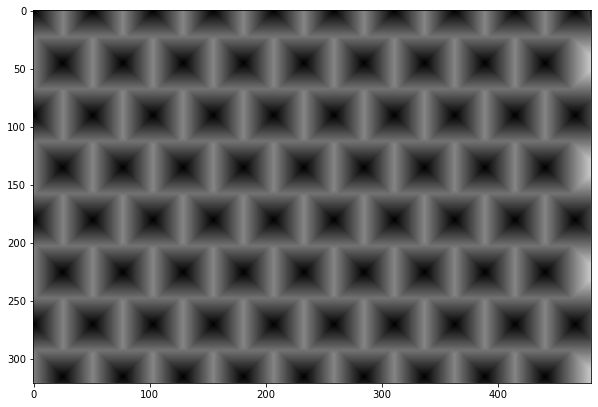

In [14]:
cart = cartedesdistances(ima,centres)
nl,nc = cart.shape
plt.figure(figsize = (10,10))
plt.imshow(cart,cmap='gray')

### **D5,7,11 de masques**
**Avant :**
\begin{bmatrix}
 & 11 &  & 11 &\\
11 & 7 & 5 & 7 & 11\\
 & 5 & 0 & &
\end{bmatrix}

**Arriere :**
\begin{bmatrix}
 &  & 0 & 5 &\\
11 & 7 & 5 & 7 & 11\\
 & 11 & & 11 &
\end{bmatrix}

In [15]:
def cartedesdistances_improved(im,centres):
  
  nl,nc=im.shape
  carte=np.zeros((nl,nc))
   #Initialisation
  carte.fill(10000)
  for point in centres:
    carte[int(point[1]),[int(point[0])]]=0
    #premier demi masque
    mask1= np.array([10000,11,10000,11,10000,11,7,5,7,11,10000,5,0,10000,10000])
    mask1=mask1.reshape((3,5))
    
  #premier balayage
  for x in range(nl-2):
      for y in range (nc-4):
         l=[]
         for i in range(5):
            for j in range(3):
                l.append(carte[x+j,y+i]+mask1[j,i])
         carte[x+2,y+2]=np.min(l)
#Correction des effets de bords
  carte[0][0]=np.min([carte[0][0],carte[0][1]+1,carte[1][0]+1])
  carte[0][nc-1]=np.min([carte[0][nc-1],carte[0][2]+1,carte[1][nc-1]+1])
  carte[nl-1][0]=np.min([carte[nl-1][0],carte[nl-2][0]+1,carte[nl-1][1]+1])
  carte[nl-1][nc-1]=np.min([carte[nl-1][nc-1],carte[nl-2][nc-1]+1,carte[nl-1][nc-2]+1])
  for x in range (1,nl-1):
    carte[x][0]=np.min([carte[x][0],carte[x][1]+1,carte[x+1][0]+1,carte[x-1][0]+1])
    carte[x][nc-1]=np.min([carte[x][nc-1],carte[x][nc-2]+1,carte[x-1][nc-1]+1,carte[x+1][nc-1]+1])
  for y in range(1,nc-1):
    carte[0][y]=np.min([carte[0][y],carte[0][y-1]+1,carte[0][y+1]+1,carte[1][y]+1])


    #deuxiemme demi masque
  mask2= np.array([10000,10000,0,5,10000,11,7,5,7,11,10000,11,10000,11,10000])
  mask2=mask2.reshape((3,5))
    
    #deuxiemme balayage
  for x in range(nl-3,-1,-1):
    for y in range(nc-5,-1,-1):
      l=[]
      for i in range(5):
        for j in range(3):
            l.append(carte[x+j,y+i]+mask2[j,i])
      carte[x,y+2]=np.min(l)  
    #Correction des effets de bords
  carte[0][0]=np.min([carte[0][0],carte[0][1]+1,carte[1][0]+1])
  carte[0][nc-1]=np.min([carte[0][nc-1],carte[0][2]+1,carte[1][nc-1]+1])
  carte[nl-1][0]=np.min([carte[nl-1][0],carte[nl-2][0]+1,carte[nl-1][1]+1])
  carte[nl-1][nc-1]=np.min([carte[nl-1][nc-1],carte[nl-2][nc-1]+1,carte[nl-1][nc-2]+1])
  for x in range (1,nl-1):
    carte[x][0]=np.min([carte[x][0],carte[x][1]+1,carte[x+1][0]+1,carte[x-1][0]+1])
    carte[x][nc-1]=np.min([carte[x][nc-1],carte[x][nc-2]+1,carte[x-1][nc-1]+1,carte[x+1][nc-1]+1])
  for y in range(1,nc-1):
    carte[nl-1][y]=np.min([carte[nl-1][y],carte[nl-1][y-1]+1,carte[nl-1][y+1]+1,carte[nl-2][y]+1])

  return(carte[:,:])
          



**Affichage des résultats**

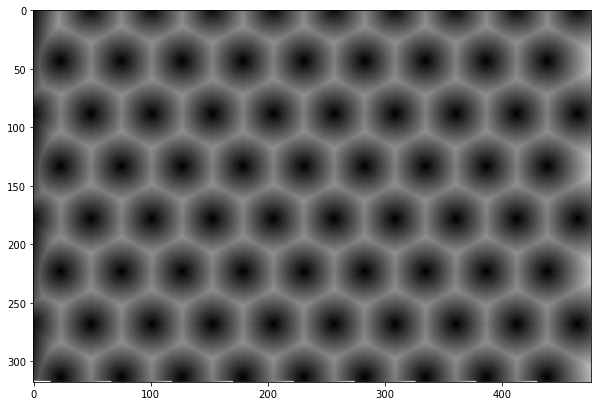

In [16]:
cart1 = cartedesdistances_improved(ima,centres)
cart1 = cart1[2:nl-1,2:nc-2]
plt.figure(figsize = (10,10))
plt.imshow(cart1,cmap='gray')

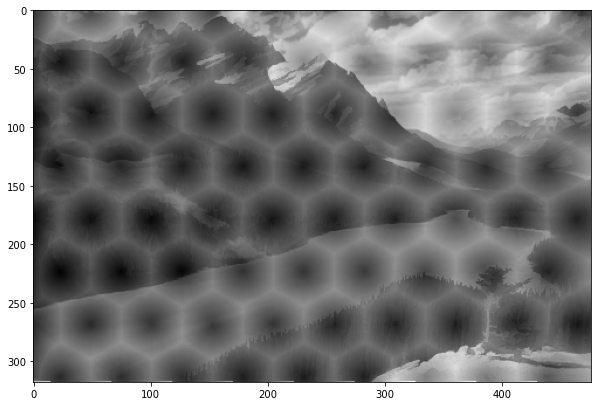

In [17]:
image_cart = cart1 + ima[2:nl-1,2:nc-2]
plt.figure(figsize = (10,10))
plt.imshow(image_cart,cmap='gray')

# **Etiquetage en composantes connexes**

### **Premiere méthode par récursivité**

In [18]:
def voisinage(i,j,l,c):
  v = []
  for k in range(-1,2):
      point = [i+k,j]
      if (point[0] >= 0) and (point[0] <= l-1) and (point[1] >= 0) and (point[1] <= c-1):
        v.append(point)
  for k in range(-1,2):
      point = [i,j+k]
      if (point[0] >= 0) and (point[0] <= l-1) and (point[1] >= 0) and (point[1] <= c-1):
        v.append(point)
  
  return v

In [19]:
def locallabeling(p,im,labels,label):

  l, c = im.shape

  if im[p[0],p[1]] != 0:
        
    v = voisinage(p[0],p[1],l,c)
    labels[p[0], p[1]] = label
    im[p[0], p[1]] = 0
    
    for vp in v:
        px, py = vp
        locallabeling(vp,im,labels,label)

In [20]:
def labeling(ima):
    
  im = ima[:,:]

  l, c = im.shape

  labels = np.zeros((l,c),dtype=int)

  nnul = np.where(im!=0)

  label = 0

  while len(nnul[0])!=0:

    p = [ nnul[0][0], nnul[1][0]]

    label += 1

    locallabeling(p,im,labels,label)

    nnul = np.where(im!=0)

  return(labels)



### **Deuxieme méthode classique**

In [21]:
def newlabel(k, l):

  label = k

  for i in l:

    a = i[0]
    b = i[1]

    if a == k and b < label:
      label = b

  return label

In [22]:
def labvoisinage(tab, i, j, label):

  l,c = tab.shape
  loclabels = [label]
  res = label
  chang = [(label,label)]

  for k in range(-1,2):
    for p in range(-1,2):

      if (i+k >= 0) and (i+k <= l-1) and (j+p >= 0) and (j+p <= c-1):
        lab = tab[i+k,j+p]

        if lab != 0 :
          loclabels.append(lab)

  res = min(loclabels)

  for l in loclabels:
      chang.append((l,res))
      
  return res, chang

In [23]:
def etiquetage(im):

  l,c = im.shape
  labels = np.zeros((l,c),dtype=int)
  changements = []
  label = 1
  newlabs = []

  for i in range(l):
    for j in range(c):

      if im[i,j] != 0 :
        lab, chang = labvoisinage(labels, i, j, label)
        labels[i,j] = lab
        changements = changements + chang
        label += 1
        print(label)
  
  for i in range(1,label):
    newlabs.append((i,newlabel(i, changements)))

  for i in range(l):
    for j in range(c):

      if im[i,j] != 0 :
        inter = labels[i,j]
        labels[i,j] = newlabel(inter, newlabs)


  return labels

**Affichage des résultats**

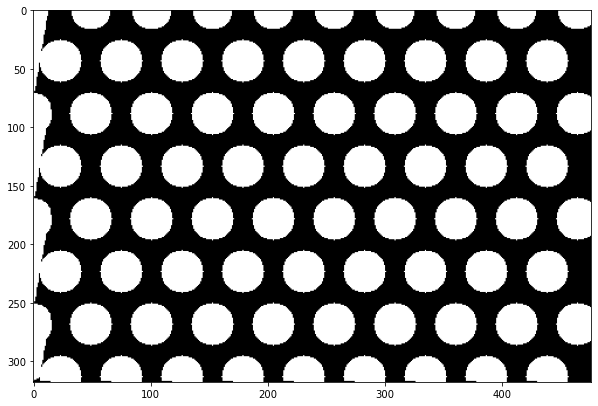

In [24]:
cartnew = cart1
cartnew = np.where(cartnew == 0, 1, cartnew) 
cartnew = np.where(cartnew > 90, 0, cartnew) 
cartnew = np.where(cartnew != 0,1,cartnew)

plt.figure(figsize = (10,10))
plt.imshow(cartnew,cmap='gray')

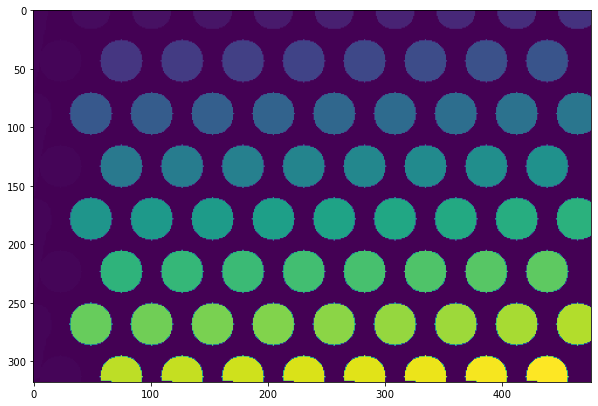

In [25]:
labels = labeling(cartnew)
plt.figure(figsize = (10,10))
plt.imshow(labels)

# **Sélection des marqueurs**

In [26]:
def selection_des_marqueurs(gradlab,nbr_cells,img_label):
  
  nl,nc = gradlab.shape
  marqueur = np.zeros((nl,nc))  
  points = []
    
  for k in range(1,nbr_cells+1):
    gradient_cellule = np.zeros((nl,nc))
    gradient_cellule.fill(255)
    abscisse,ordonnee = np.where(img_label==k)
    for i in range (len(abscisse)):
        gradient_cellule[abscisse[i]][ordonnee[i]]=gradlab[abscisse[i]][ordonnee[i]]
    minimun_grad=np.where(gradient_cellule == gradient_cellule.min())
    minimun_grad=[list(minimun_grad[0]),list(minimun_grad[1])]
    if len(minimun_grad[0])==0:
        x=abscisse[len(abscisse)//2]
        y=ordonnee[len(ordonnee)//2]
        marqueur[x][y]=1
        points.append((y,x))

    else:
        mat = np.zeros((nl,nc))
        for i in range (len(minimun_grad[0])):
            mat[minimun_grad[0][i],minimun_grad[1][i]] = 1
        labels2 = labeling(mat)
        nbcomp = int(np.amax(labels2))
        max = 0
        comp = 1
        for k in range(1,nbcomp+1):
            long = len(np.where(labels2==k))
            if long > max :
                max = long
                comp = k

        abscisse,ordonnee=np.where(labels2==comp)

        for i in range (len(abscisse)):
            marqueur[abscisse[i]][ordonnee[i]] = 1
            points.append((ordonnee[i],abscisse[i]))
    
  return (marqueur, points)

**Affichage des résultats**

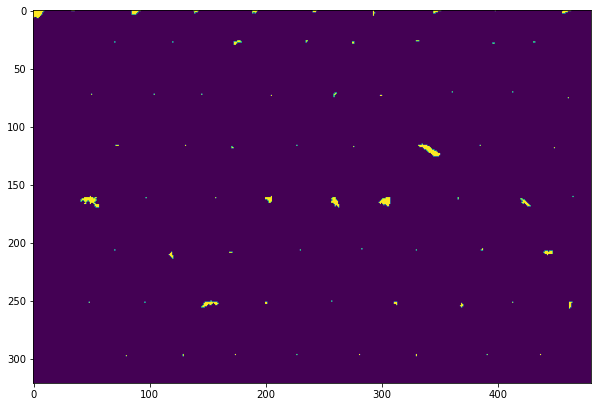

In [27]:
cells = int(np.amax(labels))
  
# Selection des marqueurs
sel = selection_des_marqueurs(grad_morpho,cells,labels)
marqueur = sel[0]
plt.figure(figsize = (10,10))
plt.imshow(marqueur)

# **Régularisation des gradients**

In [28]:
def regularisation(grad, distmap, k,taille_cellule):
    n,m = np.shape(grad)
    res = 0*np.ones((n,m))
    for i in range(n):
        for j in range(m):
            res[i,j] = grad[i,j]+k*(2*distmap[i,j])/taille_cellule
    return res

**Affichage des résultats**

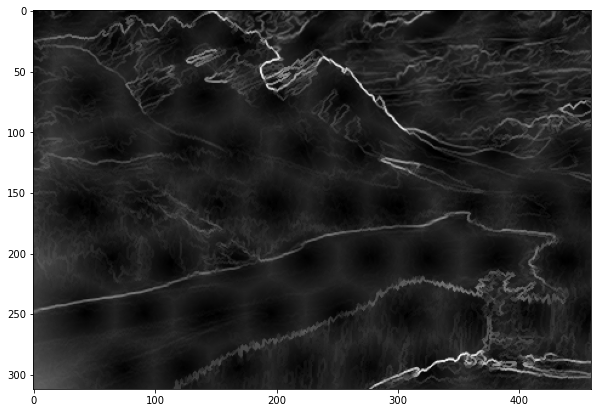

In [32]:
points = sel[1]
    
nl,nc = grad_morpho.shape
grad_morpho = grad_morpho[2:nl-1,5:nc-2] 
    
# Régularisation du gradient
cart2 = cartedesdistances_improved(ima,points)
nl,nc = cart2.shape
cart2 = cart2[2:nl-1,5:nc-2] 
reggrad = regularisation(grad_morpho, cart2, 3,30)
plt.figure(figsize = (10,10))
plt.imshow(reggrad,cmap='gray')

# **Seuillage de l'image**

In [33]:
def seuillage(im, s):
    cartnew = im
    cartnew = np.where(cartnew == 0, 1, cartnew) 
    cartnew = np.where(cartnew > s, 0, cartnew) 
    cartnew = np.where(cartnew != 0,1,cartnew)
    
    return cartnew

# **Réglage de taille**

In [34]:
def reglagetaille(ima):
    nl,nc = ima.shape
    ima = ima[2:nl-1,5:nc-2] 
    return ima

#pour l'adaptation à la carte de distance à grille hexagonale

# **Première approche** : Meilleure adhérence

In [35]:
def waterpixels(image, k, step, aff='1'):
    
    # Importation de l'image
    imname = './' + image + '.jpg'
    img = io.imread(imname)
    ima = img[:,:,0]
    img = np.asarray(img)
    
    # Pré-traitement de l'image
    ima = preprocessing(ima, step)
    
    # Calcul du gradient
    grad_morpho = gradmorpho(ima)
    
    im = Image.fromarray(np.uint8(grad_morpho))
    
    # Construction de la grille
    Im,centres = hexagon(im, step)
    
    # Calcul de la carte de distances
    cart1 = cartedesdistances_improved(ima,centres)
    cart1 = reglagetaille(cart1)
    
    nl,nc = ima.shape
    image_cart = cart1 + reglagetaille(ima)
    
    # Seuillage de la carte de distances
    cartnew = seuillage(cart1, 90)
    
    # Etiquetage en composantes connexes
    labels = labeling(cartnew)
    cells = int(np.amax(labels))
    
    # Selection des marqueurs
    sel = selection_des_marqueurs(grad_morpho,cells,labels)
    marqueur = sel[0]
    points = sel[1]
    
    grad_morpho = reglagetaille(grad_morpho)
    
    # Régularisation du gradient
    cart2 = cartedesdistances_improved(ima,points)
    cart2 = reglagetaille(cart2)
    reggrad = regularisation(grad_morpho, cart2, k,step)
    
    marqueur = reglagetaille(marqueur)
    marqueur = labeling(marqueur)
    
    # Application du watershed
    ws = watershed(reggrad, marqueur,watershed_line = True)
    
    ima = reglagetaille(ima)
    bound = mark_boundaries(ima,ws)
    
    
    if aff == '1':
        fig,ax = plt.subplots(5,2,figsize = (50,80))
        ax[0,0].imshow(img)
        ax[0,0].set_title('Image originale')
        ax[0,1].imshow(gradlab,cmap='gray')
        ax[0,1].set_title('Gradient Lab de l''image')
        ax[1,0].imshow(Im,cmap='gray')
        ax[1,0].set_title('Grille hexagonale')
        ax[1,1].imshow(cart1,cmap='gray')
        ax[1,1].set_title('Carte de distance')
        ax[2,0].imshow(image_cart,cmap='gray')
        ax[2,0].set_title('Carte de distance appliquée a l''image')
        ax[2,1].imshow(cartnew,cmap='gray')
        ax[2,1].set_title('Carte de distance après seuillage')
        ax[3,0].imshow(labels)
        ax[3,0].set_title('Carte de distance après étiquetage')
        ax[3,1].imshow(marqueur)
        ax[3,1].set_title('Selection des marqueurs')
        ax[4,0].imshow(bound)
        ax[4,0].set_title('Superpixels boundaries')
        ax[4,1].imshow(ws)
        ax[4,1].set_title('Watershed result')
    
    return ws

# **Deuxième approche** : Meilleure régularité

In [36]:
def waterpixels2(image, k, step, aff='1'):
    
    # Importation de l'image
    imname = './' + image + '.jpg'
    img = io.imread(imname)
    ima = img[:,:,0]
    img = np.asarray(img)
    
    # Pré-traitement de l'image
    ima = preprocessing(ima, step)
    
    # Calcul du gradient
    gradlab = gradientlab(img)
    
    im = Image.fromarray(np.uint8(grad_morpho))
    
    # Construction de la grille
    Im,centres = hexagon(im, step)
    
    # Calcul de la carte de distances
    cart1 = cartedesdistances_improved(ima,centres)
    
    cart1 = reglagetaille(cart1)
    
    nl,nc = ima.shape
    image_cart = cart1 + reglagetaille(ima)
    
    # Seuillage de la carte de distances
    cartnew = seuillage(cart1, 90)
    
    # Etiquetage en composantes connexes
    labels = labeling(cartnew)
    cells = int(np.amax(labels))
        
    gradlab = reglagetaille(gradlab)
    
    # Régularisation du gradient
    reggrad = regularisation(gradlab,cart1, k,step)
    
    # Application du watershed
    ws = watershed(reggrad, labels,watershed_line = True)
    
    ima = reglagetaille(ima)
    bound = mark_boundaries(ima,ws)

    if aff == '1':
        fig,ax = plt.subplots(5,2,figsize = (50,80))
        ax[0,0].imshow(img)
        ax[0,0].set_title('Image originale')
        ax[0,1].imshow(gradlab,cmap='gray')
        ax[0,1].set_title('Gradient Lab de l''image')
        ax[1,0].imshow(Im,cmap='gray')
        ax[1,0].set_title('Grille hexagonale')
        ax[1,1].imshow(cart1,cmap='gray')
        ax[1,1].set_title('Carte de distance')
        ax[2,0].imshow(image_cart,cmap='gray')
        ax[2,0].set_title('Carte de distance appliquée a l''image')
        ax[2,1].imshow(cartnew,cmap='gray')
        ax[2,1].set_title('Carte de distance après seuillage')
        ax[3,0].imshow(labels)
        ax[3,0].set_title('Carte de distance après étiquetage')
        ax[3,1].imshow(marqueur)
        ax[3,1].set_title('Selection des marqueurs')
        ax[4,0].imshow(bound)
        ax[4,0].set_title('Superpixels boundaries')
        ax[4,1].imshow(ws)
        ax[4,1].set_title('Watershed result')
    
    return ws

# **Métriques**

In [37]:
def FourConnected(lab, i, j) :
    
    l,c = lab.shape
    
    if (i > 0) :
        if (lab[i, j] != lab[i - 1, j]) :
            return True
    
    if (i < l - 1) :
        if (lab[i, j] != lab[i+1, j]) :
            return True
    
    if (j > 0) :
        if (lab[i, j] != lab[i, j-1]) :
            return True
    
    if (j < c - 1) :
        if (lab[i, j] != lab[i, j+1]) :
            return True
    
    return False

In [38]:
def BoundaryRecall(lab, gt, d):

    H = gt.shape[0]
    W = gt.shape[1]
    
    r = round( d* math.sqrt(H*H + W*W))
   
    TP = 0
    FN = 0

    for i in range(H):
        for j in range(W):
            
            if (FourConnected(gt, i, j)) :
                pos = False
        
                for k in range(max(0, i - r), min(H - 1, i + r) + 1):
                    for l in range(max(0, j - r), min(W - 1, j + r) + 1):
                        
                        if (FourConnected(lab, k, l)) :
                            pos = True
                            
                TP += pos
                FN += 1 - pos

    
    if (TP + FN > 0) :
        return TP/(TP + FN)
    
    return 0

In [39]:
def ContourDensity(labels, Slic = False):
    
  l,c = labels.shape

  nbpixels = l*c
    
  Sb = 2*(l+c) - 4

  Sc = len(np.where(labels==0)[0])

  if Slic:
    CD = (Sc//2+Sb)/nbpixels
  else :
    CD = (Sc+Sb)/nbpixels # boundaries are 1-pixel wide (SLIC)

  return CD

# **Chargement de la référence**

In [40]:
from scipy.io import loadmat

def loadgroundtruth(im):
    im = im + '.mat'
    annots = loadmat(im)
    gt = annots["groundTruth"][0][0][0][0][0]
    gt = reglagetaille(gt)
    
    return gt

# **SLIC**

In [41]:
from skimage.segmentation import slic

def slic_seg(image):
    imname = './' + image + '.jpg'
    img = io.imread(imname)
    res = slic(img)
    bound= mark_boundaries(img,res)
    plt.imshow(bound)
    
    return res

# **Evaluation des paramètres**

In [52]:
step = 30
d = 0.005
image = '2018'
k = 10
w1 = []
w2 = []
cd1 = []
cd2 = []

gt=loadgroundtruth(image)

for k in range(0,20,2):
    wp1 = waterpixels(image, k, step, aff='0')
    wp2 = waterpixels2(image, k, step, aff='0')
    
    w1.append(BoundaryRecall(wp1, gt, d))
    w2.append(BoundaryRecall(wp2, gt, d))
    
    cd1.append(ContourDensity(wp1))
    cd2.append(ContourDensity(wp2))

### **Influence du paramètre k**

Text(0, 0.5, 'Boundary Recall')

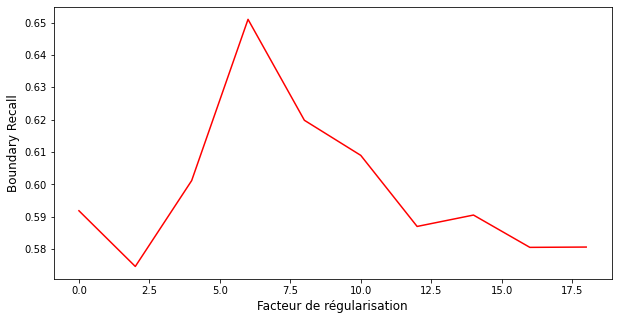

In [53]:
k = range(0,20,2)
plt.figure(figsize=(10,5))

# Plotting both the curves simultaneously
plt.plot(k, w1, color='r', label='Waterpixels')
plt.xlabel("Facteur de régularisation", fontsize= 12)
plt.ylabel("Boundary Recall", fontsize= 12)

### **Comparaison entre les deux approches**

Text(0, 0.5, 'Boundary Recall')

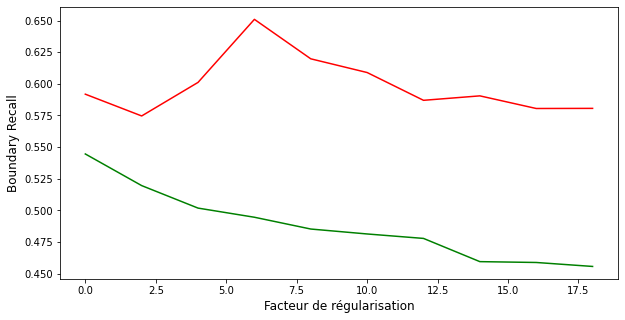

In [54]:
k = range(0,20,2)
plt.figure(figsize=(10,5))

# Plotting both the curves simultaneously
plt.plot(k, w1, color='r', label='Premiere approche')
plt.plot(k, w2, color='g', label='Deuxieme approche')

plt.xlabel("Facteur de régularisation", fontsize= 12)
plt.ylabel("Boundary Recall", fontsize= 12)

Text(0, 0.5, 'Contour Density')

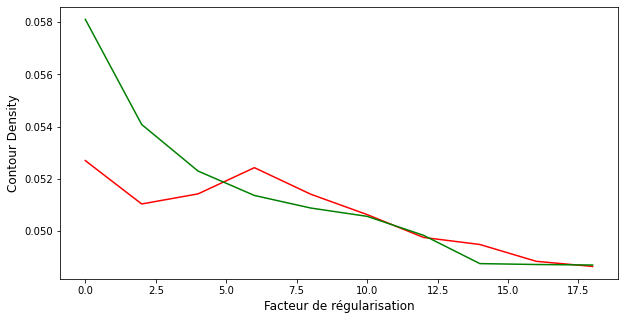

In [55]:
k = range(0,20,2)
plt.figure(figsize=(10,5))

# Plotting both the curves simultaneously
plt.plot(k, cd1, color='r', label='Premiere approche')
plt.plot(k, cd2, color='g', label='Deuxieme approche')

plt.xlabel("Facteur de régularisation", fontsize= 12)
plt.ylabel("Contour Density", fontsize= 12)

### **Comparaison entre Waterpixels et SLIC**

C:\Users\KHALIL\AppData\Local\Temp/ipykernel_10972/1073609573.py:6: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  res = slic(img)


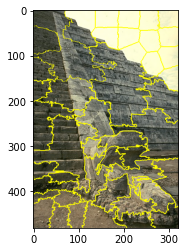

In [59]:
images = ['2018', '6046', '20069', '61034', '33044']
k = 8
step = 30
d = 0.005
w = []
s = []
cd1 = []
cd2 = []

for i in images:
    wp = waterpixels(i, k, step, aff='0')
    sl = slic_seg(i)
    gt = loadgroundtruth(i)
    
    w.append(BoundaryRecall(wp, gt, d))
    s.append(BoundaryRecall(sl, gt, d))
    
    cd1.append(ContourDensity(wp))
    cd2.append(ContourDensity(sl,True))

Text(0, 0.5, 'Boundary Recall')

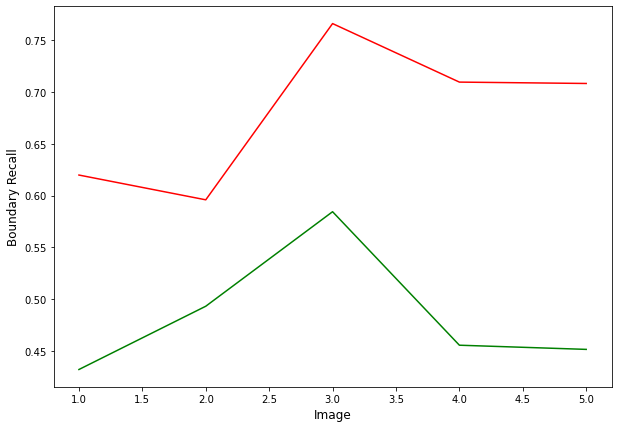

In [60]:
k = range(1,6)
# Plotting both the curves simultaneously
plt.figure(figsize = (10,7))
plt.plot(k, w, color='r', label='Waterpixels')
plt.plot(k, s, color='g', label='Slic')
plt.xlabel("Image", fontsize= 12)
plt.ylabel("Boundary Recall", fontsize= 12)

Text(0, 0.5, 'Contour Density')

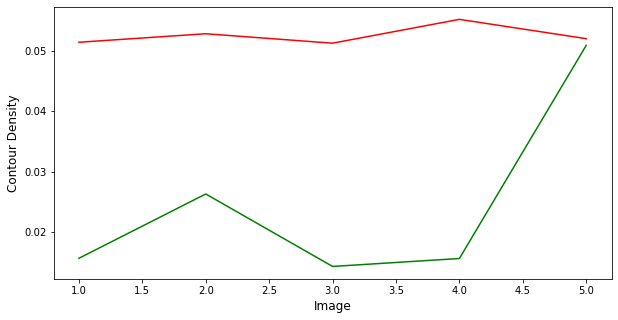

In [62]:
k = range(1,6)
plt.figure(figsize=(10,5))

# Plotting both the curves simultaneously
plt.plot(k, cd1, color='r', label='Waterpixels')
plt.plot(k, cd2, color='g', label='SLIC')

plt.xlabel("Image", fontsize= 12)
plt.ylabel("Contour Density", fontsize= 12)

C:\Users\KHALIL\AppData\Local\Temp/ipykernel_10972/1073609573.py:6: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  res = slic(img)


Text(0.5, 1.0, 'SP par SLIC')

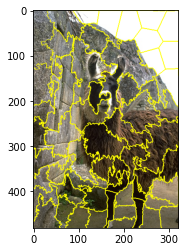

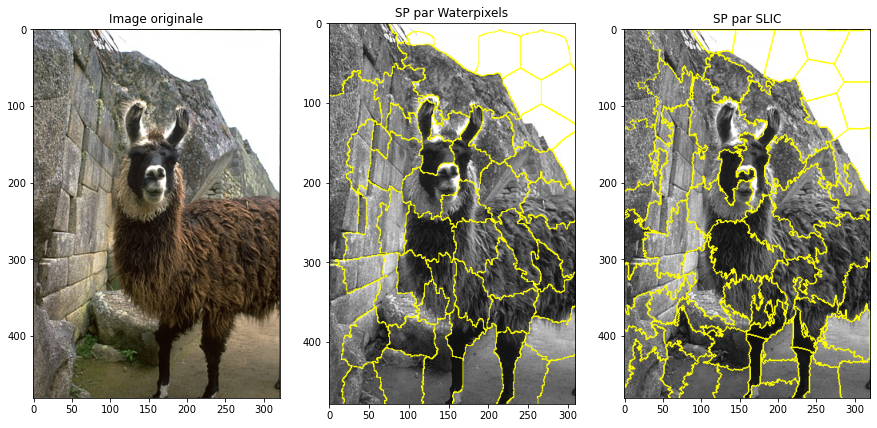

In [63]:
image = '6046'
k = 10
step = 30

imname = './' + image + '.jpg'
img = io.imread(imname)
ima2 = img[:,:,0]
ima = reglagetaille(ima2)

wp = waterpixels(image, k, step, aff='0')
bound = mark_boundaries(ima,wp)
sl = slic_seg(image)
bound2 = mark_boundaries(ima2,sl)

fig,ax = plt.subplots(1,3,figsize = (15,40))
ax[0].imshow(img)
ax[0].set_title('Image originale')
ax[1].imshow(bound)
ax[1].set_title('SP par Waterpixels')
ax[2].imshow(bound2)
ax[2].set_title('SP par SLIC')

### **Comparaison des deux approches de Waterpixels**

Text(0.5, 1.0, 'SP par la deuxieme approche')

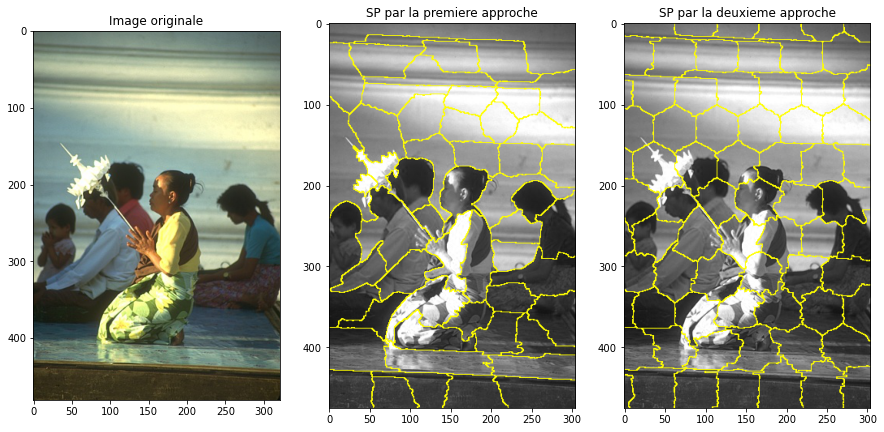

In [67]:
image = '20069'
k = 7
step = 30

imname = './' + image + '.jpg'
img = io.imread(imname)
ima2 = img[:,:,0]
ima = reglagetaille(ima2)

wp = waterpixels(image, k, step, aff='0')
bound = mark_boundaries(ima,wp)
wp2 = waterpixels2(image, k, step, aff='0')
bound2 = mark_boundaries(ima,wp2)

fig,ax = plt.subplots(1,3,figsize = (15,40))
ax[0].imshow(img)
ax[0].set_title('Image originale')
ax[1].imshow(bound)
ax[1].set_title('SP par la premiere approche')
ax[2].imshow(bound2)
ax[2].set_title('SP par la deuxieme approche')

Text(0.5, 1.0, 'K = 50')

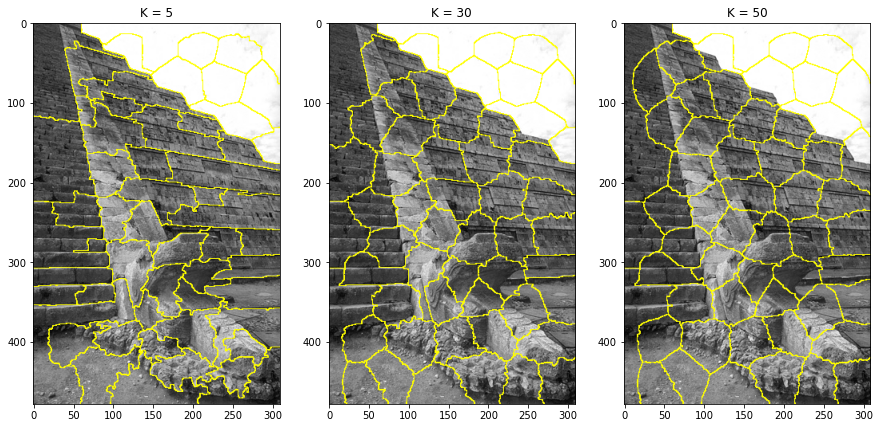

In [58]:
image = '33044'
ks = [5, 30, 50]
step = 30

imname = './' + image + '.jpg'
img = io.imread(imname)
ima = img[:,:,0]
ima = reglagetaille(ima)

wp1 = waterpixels(image, ks[0], step, aff='0')
bound1 = mark_boundaries(ima,wp1)

wp2 = waterpixels(image, ks[1], step, aff='0')
bound2 = mark_boundaries(ima,wp2)

wp3 = waterpixels(image, ks[2], step, aff='0')
bound3 = mark_boundaries(ima,wp3)


fig,ax = plt.subplots(1,3,figsize = (15,40))
ax[0].imshow(bound1)
ax[0].set_title('K = 5')
ax[1].imshow(bound2)
ax[1].set_title('K = 30')
ax[2].imshow(bound3)
ax[2].set_title('K = 50')

### **Influence du paramètre step**

In [49]:
steps = [30,40,50,60,70]
image = '33044'
k = 10
d = 0.005
br1 = []
br2 = []
cd1 = []
cd2 = []
gt = loadgroundtruth(image)

for s in steps:
    
    wp = waterpixels(image, k, s, aff='0')
    wp2 = waterpixels2(image, k, s, aff='0')
    
    br1.append(BoundaryRecall(wp, gt, d))
    br2.append(BoundaryRecall(wp2, gt, d))
    
    cd1.append(ContourDensity(wp))
    cd2.append(ContourDensity(wp2))

Text(0, 0.5, 'Boundary Recall')

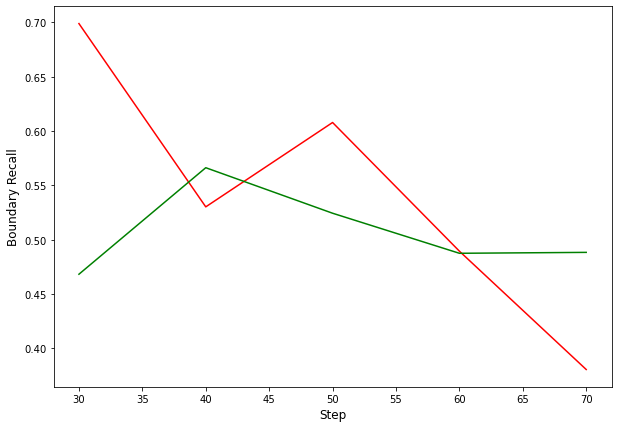

In [50]:
steps = [30,40,50,60,70]
# Plotting both the curves simultaneously
plt.figure(figsize = (10,7))
plt.plot(steps, br1, color='r', label='Waterpixels app1')
plt.plot(steps, br2, color='g', label='Waterpixels app1')
plt.xlabel("Step", fontsize= 12)
plt.ylabel("Boundary Recall", fontsize= 12)

Text(0, 0.5, 'Contour Density')

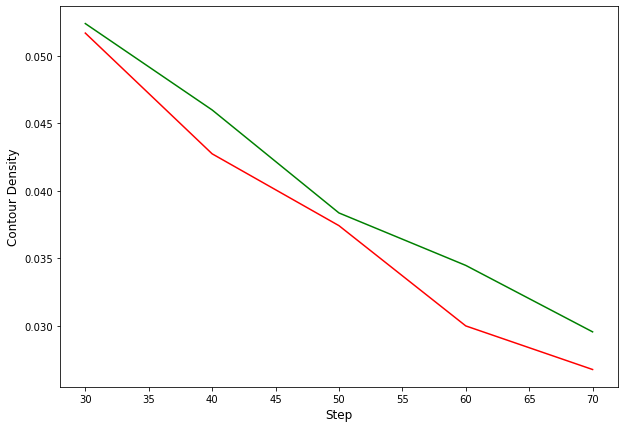

In [51]:
steps = [30,40,50,60,70]
# Plotting both the curves simultaneously
plt.figure(figsize = (10,7))
plt.plot(steps, cd1, color='r', label='Waterpixels app1')
plt.plot(steps, cd2, color='g', label='Waterpixels app1')
plt.xlabel("Step", fontsize= 12)
plt.ylabel("Contour Density", fontsize= 12)

### **Différents résultats de watersheds**

Text(0.5, 1.0, 'Watershed sur limage 20069')

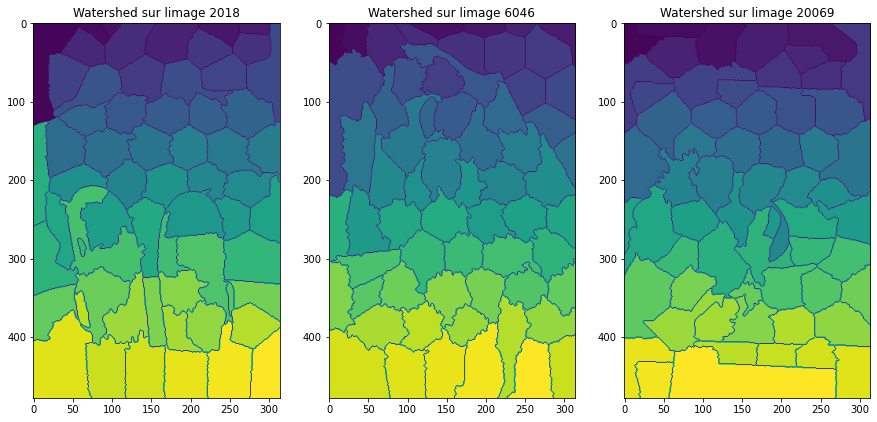

In [70]:
images = ['2018', '6046', '20069']
k = 8
s = 30

w1 = waterpixels(images[0], k, s, aff='0')
w2 = waterpixels(images[1], k, s, aff='0')
w3 = waterpixels(images[2], k, s, aff='0')

fig,ax = plt.subplots(1,3,figsize = (15,40))
ax[0].imshow(w1)
ax[0].set_title('Watershed sur l''image '+images[0])
ax[1].imshow(w2)
ax[1].set_title('Watershed sur l''image '+images[1])
ax[2].imshow(w3)
ax[2].set_title('Watershed sur l''image '+images[2])